### Imports

In [1]:
from data_functions import *
import copy
import os
import logging
import traceback

# sys.path.insert(1, "H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM")

import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from plot_lstm_results import plot_lstm_results
from network_models import LSTM
from train_test import train, test
from S2LDataset import S2LDataset
from print_error_report import print_error_report
from objective_functions import objective_function

# On the line below, specifiy after "from" which file the user inputs are coming from.
from input_template import (
    UserInputArgs,
    PlottingArgs,
    DataInfoArgs,
    SaveDataArgs,
    DerivedArgs,
)
from load_and_standardize import load_and_standardize
from reshape_for_time_resolution import reshape_for_time_resolution, reshape_full_series
from save_lstm import save_lstm_info, load_lstm_info
from save_lstm_results import save_lstm_results, save_lstm_test_results
from unstandardize_all_data import unstandardize_all_data

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt

### Description
Compare a MED Unimodal LSTM trained with 10 records of randomly selected bimodal seas with a Bimodal LSTM trained with 50 randomly selected records (all bimodal).

### Functions

In [2]:
# def LSTMvLAMP_df(experiment="",LSTM_files='', realization=''):
    
#     from pathlib import Path
#     import pandas as pd

#     """Makes a dataframe comparing LSTM and LAMP outputs
#         experiment = folder name of the experiment"""

#     # Establish paths
#     exp_PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\{experiment}\\'

#     # network options
#     # nwOptions = ('original', 'new')
    
#     # No experiment or network given
#     if experiment == "" or LSTM_files == '':
#         return "INVALID EXPERIMENT OR NETWORK"

#     # Parse out the variables observed
#     v1 = experiment.partition("v")[0]  # Pulls first variable by taking string before "_", spliting at the "v"
#     v2 = experiment.partition("v")[2]  # 2nd variable

#     # LAMP path
#     LAMP_path = exp_PATH + "\\LAMP_files\\"

#     # LSTM data
#     exp_PATH += LSTM_files + '\\'

#     # Set experiment path
#     # if network.lower() == "original":
#     #     exp_PATH += "\\output_files_MED\\"
#     # elif network.lower() == "new":
#     #     exp_PATH += "\\output_files_MED2_30_50\\"

#     # Make the dataframe for LSTM
#     df_LSTM = pd.DataFrame(
#         columns=[v1, v2, "Zcg", "Roll", "Pitch"]
#     )  # Create cols for the altered variables in experiement and heave, roll, pitch

#     # step through every LSTM file in the experiement to get the SSA, and add to dataframe
#     for path in Path(exp_PATH).glob(f"*{realization}.txt"):
#         # Get the SSA's
#         SSA = get_LSTM_SSA(path)
#         # Get the variable combo for the file
#         trial = path.name.lstrip("lstm_output_for_SC_")
#         idx = trial.partition(v1)[2]
#         t1 = idx.partition("_")[0]
#         if v2 == "s":
#             idx = trial.partition(v2)[2]
#             t2 = idx.partition("-")[0]
#         else:
#             idx = trial.partition(v2)[2]
#             t2 = idx.partition("_")[0]

#         SSA[v1] = float(t1)
#         SSA[v2] = float(t2)

#         df_LSTM.loc[len(df_LSTM)] = SSA

#     df_LSTM = df_LSTM.sort_values(by=[v1, v2])

#     # Make the dataframe for LAMP
#     df_LAMP = pd.DataFrame(columns=[v1, v2, "Zcg", "Roll", "Pitch"])

#     # step through every LAMP file in the experiement to get the SSA, and add to dataframe
#     for path in Path(LAMP_path).glob(f"*{realization}.mot"):
#         # Get the SSA's
#         SSA = get_LAMP_SSA(path)
#         # Get the variable combo for the file
#         trial = path.name.lstrip("LAMP_")
#         idx = trial.partition(v1)[2]
#         t1 = idx.partition("_")[0]
#         if v2 == "s":
#             idx = trial.partition(v2)[2]
#             t2 = idx.partition("-")[0]
#         else:
#             idx = trial.partition(v2)[2]
#             t2 = idx.partition("_")[0]

#         SSA[v1] = float(t1)
#         SSA[v2] = float(t2)

#         df_LAMP.loc[len(df_LAMP)] = SSA

#     df_LAMP = df_LAMP.sort_values(by=[v1, v2])

#     # Establish new, final DF for heatmap
#     df_final = pd.DataFrame(columns=[v1, v2, "Zcg Error", "Roll Error", "Pitch Error"])
#     df_final[v1] = df_LSTM[v1]
#     df_final[v2] = df_LSTM[v2]

#     # find the absolute difference between each in the series
#     df_final["Zcg Error"] = np.abs(df_LSTM["Zcg"] - df_LAMP["Zcg"])
#     df_final["Roll Error"] = np.abs(df_LSTM["Roll"] - df_LAMP["Roll"])
#     df_final["Pitch Error"] = np.abs(df_LSTM["Pitch"] - df_LAMP["Pitch"])

#     return df_final, v1, v2

In [3]:
# def makeHeatmap(experiment, parameter, realization):
#     import seaborn as sns
#     """
#     Creates a heatmap of SSA error between unimodal LSTM and same LSTM trained with bimodal seas. Given a df of the form:
#     v1      v2    Zcg Error       Roll Error    Pitch Error
#     experiment = case file
#     network = network trained on
#     parameter = parameter we want to see
#     """
#     # Set save path for the figure
#     SAVE_PATH = 'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Transfer Learning Figures\\TL5_vs_BiMod50'

#     # Set units for color bar
#     if parameter == "Zcg Error":
#         units = "meters"
#     else:
#         units = "degrees"

#     # Set the fig and ax
#     fig, (axo, axn, axd) = plt.subplots(3, figsize=(16, 16), sharey=True)
#     cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
#     fig.suptitle(f"{experiment} Absolute SSA {parameter}", fontsize=18)

#     # get the Original dataset
#     dfo, v1, v2 = LSTMvLAMP_df(experiment, 'output_files_BiMod2_30_50', realization)
#     resulto = dfo.pivot(index=v2, columns=v1, values=parameter)

#     # Set colorbar max value
#     vmax = resulto.max().max()

#     # get the new dataset
#     dfn, v1, v2 = LSTMvLAMP_df(experiment, 'output_files_MED2_30_5', realization)
#     resultn = dfn.pivot(index=v2, columns=v1, values=parameter)

#     # Set colorbar max value to that of new if it's more than med
#     if resultn.max().max() > vmax:
#         vmax = resultn.max().max()

#     # Plot original dataset
#     g1 = sns.heatmap(
#         resulto,cmap="Blues",ax=axo,cbar_kws={"label": units},cbar=True,vmax=vmax,cbar_ax=cbar_ax, annot = True, fmt = ".2f"
#     )
#     g1.invert_yaxis()
#     g1.set_title("Bimodal Training")

#     # get the new dataset
#     g2 = sns.heatmap(
#         resultn, cmap="Blues", ax=axn, cbar=True, vmax=vmax, cbar_ax=cbar_ax, annot = True, fmt = ".2f"
#     )
#     g2.invert_yaxis()
#     g2.set_title("Transfer Learning N=5")

#     # Plot a heatmap comparing the difference between the two.  Bigger is better b/c delta_orig - delta_new means new performed much better
#     dfc = dfn.copy()
#     cols =  dfo.columns.difference([v1,v2])
#     dfc[cols] = dfo[cols] - dfn[cols]
#     resultc = dfc.pivot(index=v2, columns=v1, values=parameter)
#     g3 = sns.heatmap(
#         resultc, cmap="Blues", ax=axd, cbar=True, vmax=vmax, cbar_ax=cbar_ax, annot = True, fmt = ".2f"
#     )
#     g3.invert_yaxis()
#     g3.set_title("Delta")

#     # Save the figure
#     plt.savefig(f"{SAVE_PATH}\\{experiment}_TL5_vs_BiMod50_{parameter}_{realization}.png")


### Testing HeatMaps

ERROR:root:Traceback (most recent call last):
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_32780\837978200.py", line 6, in <module>
    makeHeatmap(top_network='BiMod2_30_50',bottom_network='MED2_30_5_rand',experiment=exp, parameter="Zcg Error", realization='3', save_file='TL5_vs_BiMod50_rand')
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\data_functions.py", line 203, in makeHeatmap
    resulto = dfo.pivot(index=v2, columns=v1, values=parameter)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\venv\lib\site-packages\pandas\core\frame.py", line 7885, in pivot
    return pivot(self, index=index, columns=columns, values=values)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\venv\lib\site-packages\pandas\core\reshape\pivot.py", line 520, in pivot
    return indexed.unstack(columns_listlike)
  File "h:\OneDrive - Massachusetts Institute of Technology\The

ERROR in  hvp


ERROR:root:Traceback (most recent call last):
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_32780\837978200.py", line 6, in <module>
    makeHeatmap(top_network='BiMod2_30_50',bottom_network='MED2_30_5_rand',experiment=exp, parameter="Zcg Error", realization='3', save_file='TL5_vs_BiMod50_rand')
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\data_functions.py", line 203, in makeHeatmap
    resulto = dfo.pivot(index=v2, columns=v1, values=parameter)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\venv\lib\site-packages\pandas\core\frame.py", line 7885, in pivot
    return pivot(self, index=index, columns=columns, values=values)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\venv\lib\site-packages\pandas\core\reshape\pivot.py", line 520, in pivot
    return indexed.unstack(columns_listlike)
  File "h:\OneDrive - Massachusetts Institute of Technology\The

ERROR in  pva


KeyboardInterrupt: 

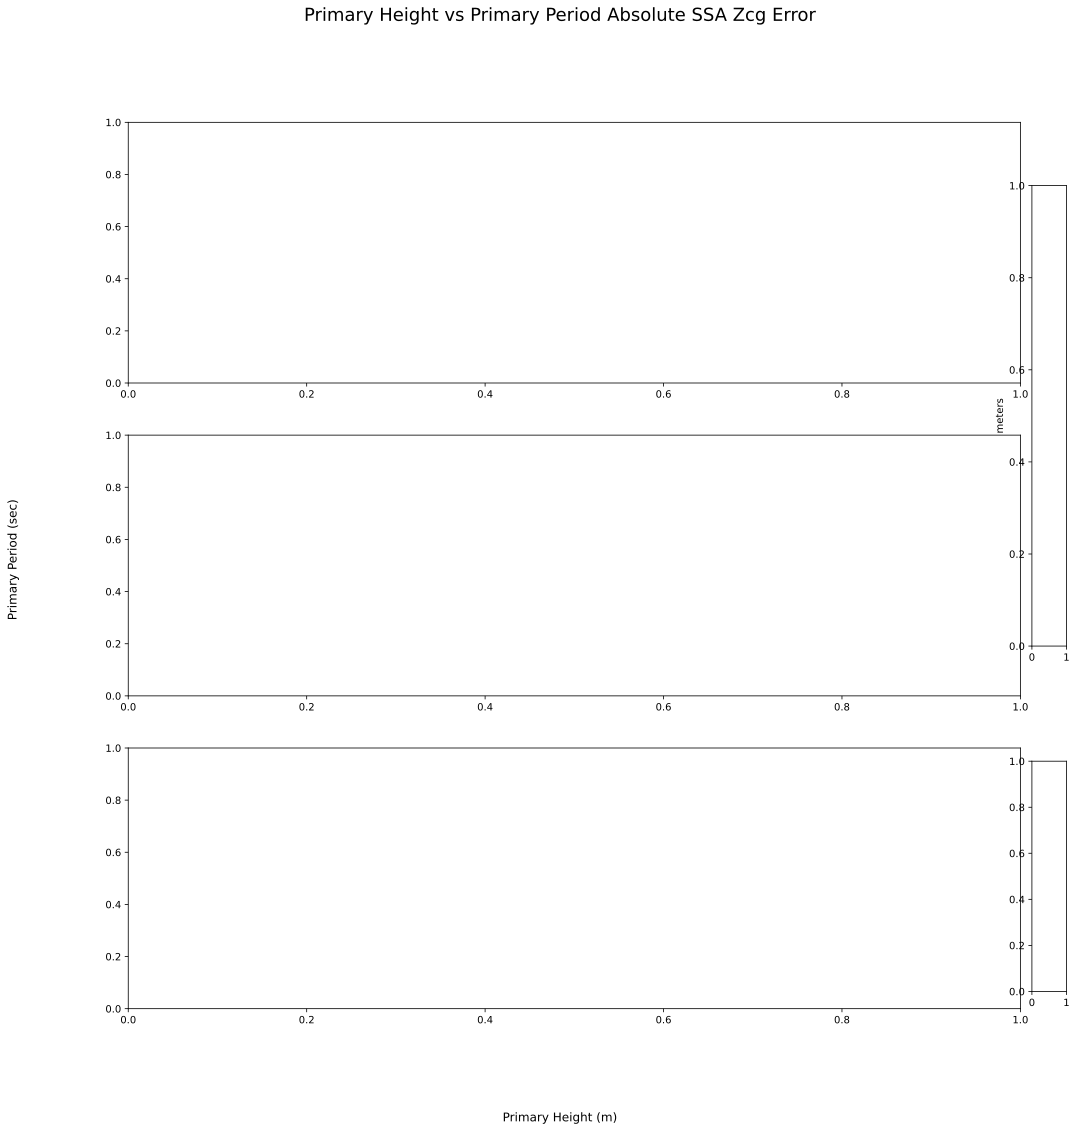

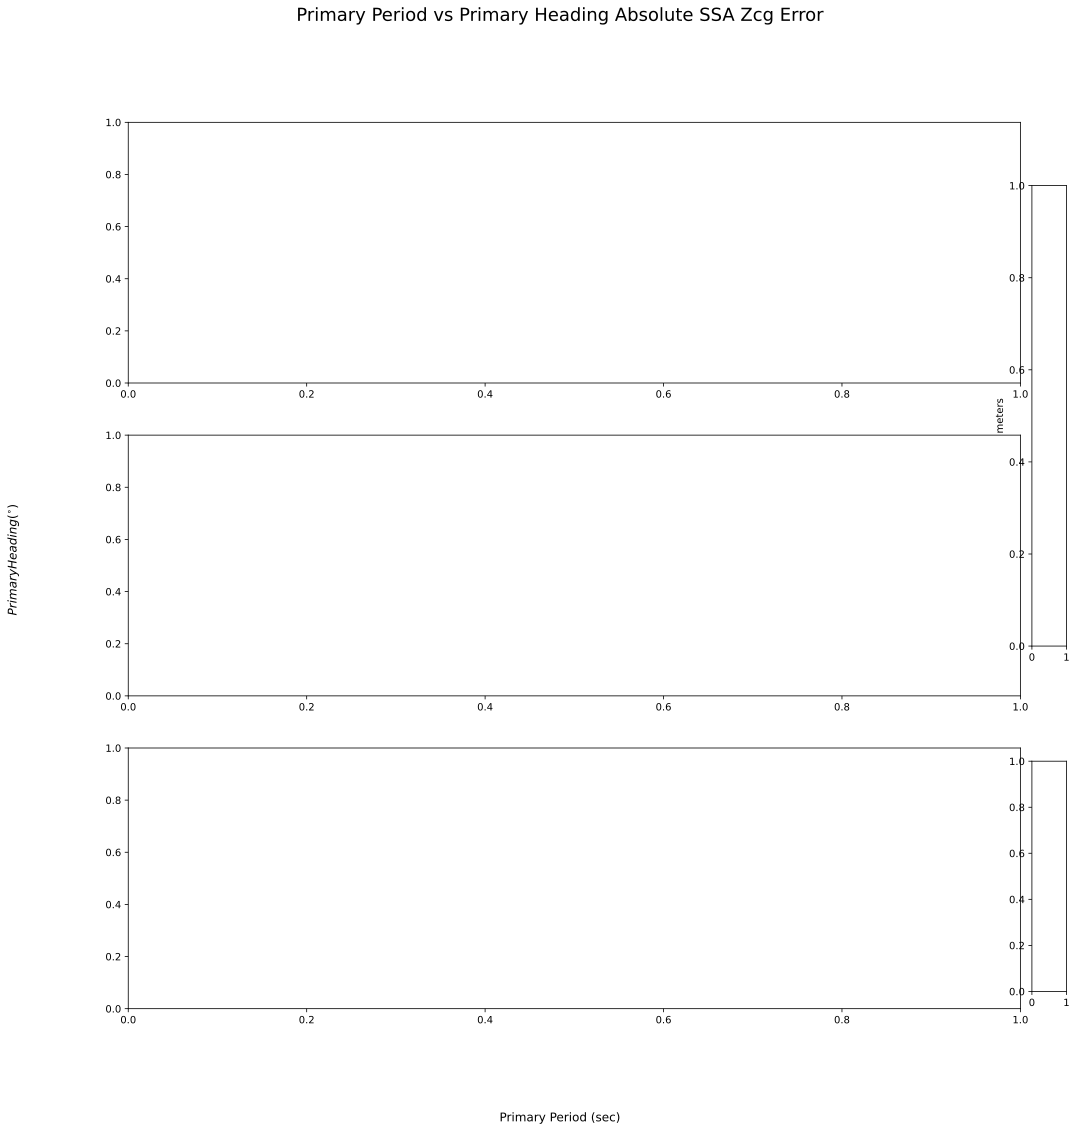

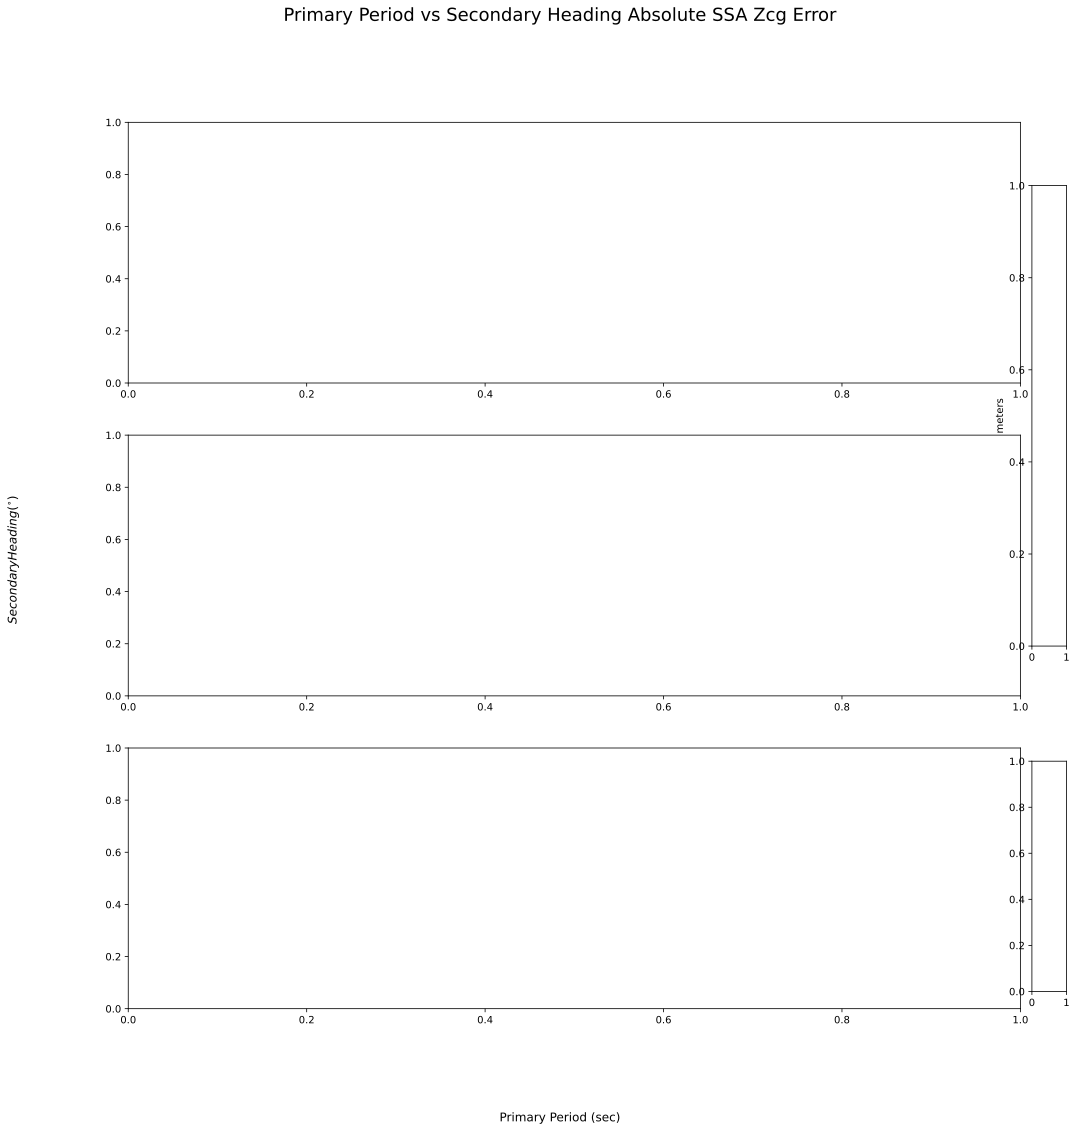

In [4]:
PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\'
ignore = ['Cases_files', '.ipynb_checkpoints','SecAngleOnly_test','__pycache__']
for exp in os.listdir(PATH):
    if os.path.isdir(PATH + exp) and exp not in ignore:
        try:
            makeHeatmap(top_network='BiMod2_30_50',bottom_network='MED2_30_5_rand',experiment=exp, parameter="Zcg Error", realization='3', save_file='TL5_vs_BiMod50_rand')
            plt.close()
            makeHeatmap(top_network='BiMod2_30_50',bottom_network='MED2_30_5_rand',experiment=exp, parameter="Roll Error", realization='3', save_file='TL5_vs_BiMod50_rand')
            plt.close()
            makeHeatmap(top_network='BiMod2_30_50',bottom_network='MED2_30_5_rand',experiment=exp, parameter="Pitch Error", realization='3', save_file='TL5_vs_BiMod50_rand')
            plt.close()
        except Exception as e:
            logging.error(traceback.format_exc())
            print('ERROR in ', exp)
            continue